<a href="https://colab.research.google.com/github/brenocsp/tic-tac-toe-boosting/blob/main/tic_tac_toe_boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementação do Algoritmo de Boosting

**Breno Claudio de Sena Pimenta**

## Introdução

Boosting é o processo de reduzir o viés de um grande conjunto de modelos simples. Esses modelos são chamados de modelos fracos, e são levemente correlacionados com a classificação correta. Nesse trabalhgo será implementado o algorítmo do Adaboost afim de classificar um conjunto de dados de jogos da velha.

## Importação das bibliotecas

Inicialmente é feito o carregamento das bibliotecas necessária.

In [ ]:
import pandas as pd
import numpy as np

from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

## Importação do dataset

Inicialmente realizamos a leitura dos dados do dataset escolhido.

In [ ]:
colNames = ["top_left", "top_middle", "top_right",
            "middle_left", "middle_middle", "middle_right",
            "bottom_left", "bottom_middle", "bottom_right",
            "class"]

df_completo = pd.read_csv('https://raw.githubusercontent.com/brenocsp/tic-tac-toe-boosting/main/tic-tac-toe.data', names=colNames, header=None)
df_completo.head(5)

,top_left,top_middle,top_right,middle_left,middle_middle,middle_right,bottom_left,bottom_middle,bottom_right,class
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


## Preparando os dados

Para preparar os dados, é feita a correção do tipo da coluna de classes *class*, visto que possui os valores *positive* e *negative* o que pode vir a dificultar os experimentos. É feita a seguinte associação numérica às classes:

*   Classe  1: positive -> vitória para o jogador *x*.
*   Classe -1: negative -> vitória para o jogador *o*.

Por fim, foram criados os vetores X e Y. O vetor X contém somente os dados numéricos das features. O vetor Y contém somente os dados das classificação dos jogos. O conjunto X e Y foram divididos em dois subconjutos de treino e de validação. O conjunto de validação é usado para tes

In [ ]:
df = df_completo.copy()
df = shuffle(df, random_state=24)

df['class'] = df['class'].replace('positive', '1', regex=True)
df['class'] = df['class'].replace('negative', '-1', regex=True)
df['class'] = df['class'].astype('int64')

X = df.copy().drop(['class'], axis=1)
X = pd.get_dummies(X).values

Y = df['class'].copy().values

x_train, x_validation, y_train, y_validation = train_test_split(X, Y, test_size=0.2, random_state=8)

## Desenvolvimento da solução

Para implementar o Boosting, foi utilizado o algoritmo do Adaboost. Ele se caracteriza por criar um classificador forte a partir de classificadores fracos. Os classificadores fracos utilizados foram árvores de decisão de profundidade 1. A seguir pode-se ver as funções básicas para a solução.

### Função de taxa de erro

Essa função é usada para calcular o erro simples, ou seja, qual a porcentagem das previsões foram incorretas.

In [ ]:
def calculeteErrorRate(y_pred, y_correct):
  return sum(y_pred != y_correct) / len(y_correct)

### Função de calcular alpha

Essa função é usada para calcular alpha, ou seja, a importancia de cada classificador fraco para compor a solução total. Esse parâmetro servirá para ponderar cada stump e será usado para atualizar os pesos das observações.

In [ ]:
def calculateAlpha(error):
  return 1/2 * np.log((1-error)/error)

### Funções auxiliares para checar classificação

As duas funções a seguir são usadas para identificar classificações incorretas. O vetor de classificações incorreta é usado para identificar quais pesos devem ser atualizados e para identificar se o peso deve ser aumentado ou diminuido em caso de erro ou acerto.

In [ ]:
def getMisclassifications(y_pred, y_correct):
  misclassifications = []
  for index, item in enumerate(y_pred):
    if y_pred[index] == y_correct[index]:
      misclassifications.append(0)
    else:
      misclassifications.append(1)
  return misclassifications 

In [ ]:
def getMisclassificationsClasses(y_pred, y_correct):
  misclassifications = []
  for index, item in enumerate(y_pred):
    if y_pred[index] == y_correct[index]:
      misclassifications.append(-1)
    else:
      misclassifications.append(1)
  return misclassifications 

### Função para atualizar parâmetros

O Adaboost precisa de atulizar os seus parametros peso e alpha para cada iteração. Essa função realiza esses cálculos e retorna os novos pesos e alpha para que em seguida sejam feitas as novas previsões.

In [ ]:
def getNewParameters(y_pred, y_correct, weights):
  miss = getMisclassifications(y_pred, y_correct)
  error = np.dot(weights, miss) / sum(weights)
  alpha = calculateAlpha(error)
  missClasses = getMisclassificationsClasses(y_pred, y_correct)
  weights = np.multiply(weights, np.exp([x * alpha for x in missClasses]))
  return alpha, weights

### Função para plotar curva de erro simples

Essa função serve para plotar as curvas de erro simples no conjunto de teste e de validação.

In [ ]:
def plotError(train_error, validation_error, interactions):
  df_error = pd.DataFrame([interactions, train_error, validation_error]).T
  df_error.columns = ['Iterações', 'Treino', 'Validação']

  plt.figure(figsize=(12,7))
  ax = plt.gca()
  df_error.plot(kind='line',x='Iterações',y='Treino',ax=ax)
  df_error.plot(kind='line',x='Iterações',y='Validação', color='orange', ax=ax)
  plt.title('Taxa de erros pelo número de interações')
  plt.show()

  return df_error

### Função do classificador Adaboost

Essa função reúne toda a implementação do classificador Adaboost. Inicialmente ela gera kfold de 5 partições para validação cruzada. Os parâmetros iniciais são o erro de treino e o erro de validação. Esses erros são os erros médios de cada partição do kfold e são calculados ao fim do processo de classificação.

A função recebe os dados de treino e teste já separados, um número de iterações (número de classificadores mais fracos), um modelo inicial (uma árvore de decisão).

Para cada partição de validação cruzada, o algoritmo faz:
1.   Inicializa os pesos como 1/n, sendo n o número de iterações
2.   Inicializa as predições inicialmente como zeros
3.   Treina o modelo atualizando alpha e os pesos.
4.   Realiza as predições no conjunto de treino e no conjunto de validação.
5.   Computa os erros nos dois conjuntos.

In [ ]:
def adaboostClassifier(x_train, x_validation, y_train, y_validation, interactions, model):
  kfold = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
  trainError = 0
  validationError = 0

  for train, test in kfold.split(x_train, y_train):
    x_train_fold, x_test_fold = x_train[train], x_train[test]
    y_train_fold, y_test_fold = y_train[train], y_train[test]

    weights = np.ones(len(x_train_fold)) / len(x_train_fold)
    y_pred_train, y_pred_validation = [np.zeros(len(x_train_fold)), np.zeros(len(x_validation))]

    for i in range(interactions):
      model.fit(x_train_fold, y_train_fold, sample_weight = weights)
      y_pred_train_i = model.predict(x_train_fold)
      y_pred_validation_i = model.predict(x_validation)
      alpha, weights = getNewParameters(y_pred_train_i, y_train_fold, weights)
      y_pred_train = [sum(x) for x in zip(y_pred_train, [x * alpha for x in y_pred_train_i])]
      y_pred_validation = [sum(x) for x in zip(y_pred_validation, [x * alpha for x in y_pred_validation_i])]
    
    y_pred_train, y_pred_validation = np.sign(y_pred_train), np.sign(y_pred_validation)
    
    trainError = trainError + calculeteErrorRate(y_pred_train, y_train_fold)
    validationError = validationError + calculeteErrorRate(y_pred_validation, y_validation)

  trainErrors = trainError/5
  validationErrors = validationError/5

  return trainErrors, validationErrors

### Função principal

Essa função é necessária para executar o trabalho inicialmente.

In [ ]:
decisionTreeClassifier = DecisionTreeClassifier(max_depth=1, random_state=7)

train_error = []
validation_error = []
interactions = [1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

for i in interactions:
  errors = adaboostClassifier(x_train, x_validation, y_train, y_validation, i, decisionTreeClassifier)
  train_error.append(errors[0])
  validation_error.append(errors[1])

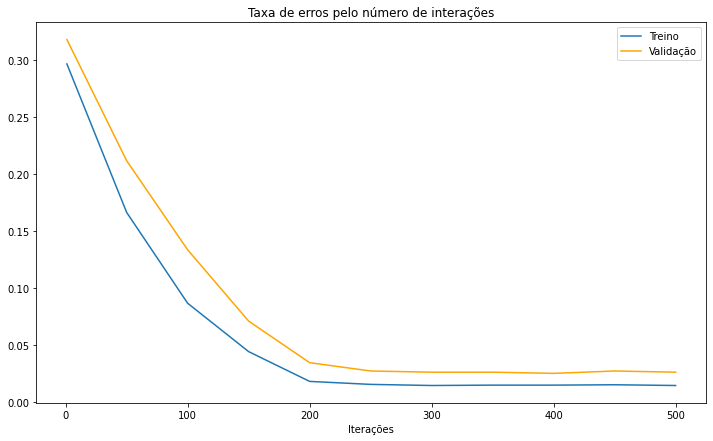

,Iterações,Treino,Validação
0,1.0,29.634285,31.770833
1,50.0,16.612129,21.145833
2,100.0,8.648829,13.333333
3,150.0,4.406327,7.083333
4,200.0,1.795147,3.437500
5,250.0,1.533975,2.708333
6,300.0,1.436096,2.604167
7,350.0,1.468669,2.604167
8,400.0,1.468669,2.500000
9,450.0,1.501295,2.708333


In [ ]:
error = plotError(train_error, validation_error, interactions)

error['Treino'] = 100*error['Treino']
error['Validação'] = 100*error['Validação']
error

## Conclusão

Por meio deste trabalho foi possível entender mais sobre o processo de boosting. Mais precisamente, foi muito relavante para aprender na prática o algoritmo do Adaboost para o problema de classificação binária do jogo da velha. 

Os resultados foram muito satisfatórios. O algoritmo implementado, ao utilizar 500 classificadores fracos, foi possível alcançar um erro de 2,604% no conjunto de validação (dados que não participaram no treino). Na tabela anterior é possível ver que usando apenas 1 stump, o erro iniciap era de 31,771% no conjunto de validação. A taxa de erro foi caindo nos dois conjuntos (treino e teste) até se estabilizar depois de 300 iterações.

Logo, é possível concluir que os resultados foram ótimos.

## Referências bibliográficas

* https://www.kdnuggets.com/2020/12/implementing-adaboost-algorithm-from-scratch.html
* https://github.com/jaimeps/adaboost-implementation
* https://towardsdatascience.com/adaboost-from-scratch-37a936da3d50
* https://www.python-engineer.com/courses/mlfromscratch/13_adaboost/
* https://medium.com/@derilraju/implementing-adaboost-classifier-from-scratch-in-python-84e1a8bd2999
* https://geoffruddock.com/adaboost-from-scratch-in-python/